In [2]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [283]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())

In [3]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

records = []
data_dir = '../../data/comfort'
i = 0
for file1, file2 in zip(bicycle_record_files, lidar_record_files):
    r1 = load_file(os.path.join(data_dir, file1), bicycle_calibration['convbike'])
    r2 = load_converted_record(os.path.join(data_dir, file2))
    r = Record(r2, r1)
    records.append(r)
    print('loaded record from files: {}, {}'.format(file1, file2))
    i += 1
    if i >= 8:
        break

loaded record from files: 2018-04-23_12-30-38.csv, 2018-04-23-12-17-37_0.pkl.gz
loaded record from files: 2018-04-23_13-13-36.csv, 2018-04-23-13-01-00_0.pkl.gz
loaded record from files: 2018-04-23_14-22-58.csv, 2018-04-23-14-10-33_0.pkl.gz
loaded record from files: 2018-04-23_15-27-48.csv, 2018-04-23-15-15-14_0.pkl.gz
loaded record from files: 2018-04-23_16-32-27.csv, 2018-04-23-16-19-35_0.pkl.gz
loaded record from files: 2018-04-23_17-14-00.csv, 2018-04-23-17-01-24_0.pkl.gz
loaded record from files: 2018-04-25_09-27-24.csv, 2018-04-25-09-15-00_0.pkl.gz
loaded record from files: 2018-04-25_10-20-28.csv, 2018-04-25-10-07-31_0.pkl.gz


In [4]:
# notes on missing syncs and repeated trials
missing_sync = [
   [680], None, None, None, None,
   None, None, None, None, None,
   None, None, None, None, None,
   None, None
]

trial_mask = [
   None, None, 0, None, None,
   0, None, None, 9, None,
   None, 11, 8, 9, None,
   None, None
]

#assert len(missing_sync) == len(records)

for i, (r, ms, tm) in enumerate(zip(records, missing_sync, trial_mask)):
    print('calculating trials for cyclist', i)
    
    try:
        r.sync()
        r._calculate_trials2(missing_sync=ms, trial_mask=tm)
    except (AssertionError, ValueError) as e:
        print('unable to calculate trials for cyclist', i)
        print(e)

calculating trials for cyclist 0
calculating trials for cyclist 1


../antlia/trial2.py:1144: UserWarning: Unable to detect cyclist exiting or braking for event ending at t = 689.011 seconds
  warnings.warn(msg, UserWarning)


calculating trials for cyclist 2
calculating trials for cyclist 3
calculating trials for cyclist 4
calculating trials for cyclist 5
calculating trials for cyclist 6
calculating trials for cyclist 7


In [243]:
metrics_kw = {'braking_threshold': 0.1, 'min_size': 75}

evt = r.trials[3].event

In [244]:
import scipy.stats
from antlia.trial2 import BrakeEventLinearFitParameters

def estimate_trajectory_velocity(event, mode='interp', xy=None):
    if xy is not None:
        x, y = xy
    else:
        x, y = event.trajectory(mode=mode)
    dx = np.diff(x)
    dy = np.diff(y)
    
    dt = np.diff(event.lidar.time)
    dt = np.mean(dt)
    v = np.zeros(x.shape)
    v[1:] = np.sqrt(np.square(dx) + np.square(dy)) / dt
    return v

def fit_velocity_brake_event(time, velocity, braking_slice=None, lockup_mask=None):
    if braking_slice is None:
        braking_slice = slice(None)
    if lockup_mask is None:
        lockup_mask = np.zeros(velocity[braking_slice].shape, dtype=bool)
        
    slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(
        time[braking_slice][~lockup_mask],
        velocity[braking_slice][~lockup_mask])
    
    fitparams = BrakeEventLinearFitParameters(
       average_window_size=None,
       braking_threshold=None,
       slice_minsize=None,
       signal_time=time,
       filtered_velocity=velocity,
       filtered_acceleration=None,
       braking_slice=braking_slice,
       lockup_mask=lockup_mask,
       linregress_slope=slope,
       linregress_intercept=intercept,
       linregress_rvalue=r_value,
       linregress_pvalue=p_value,
       linregress_stderr=stderr)
    return fitparams

<IPython.core.display.Javascript object>


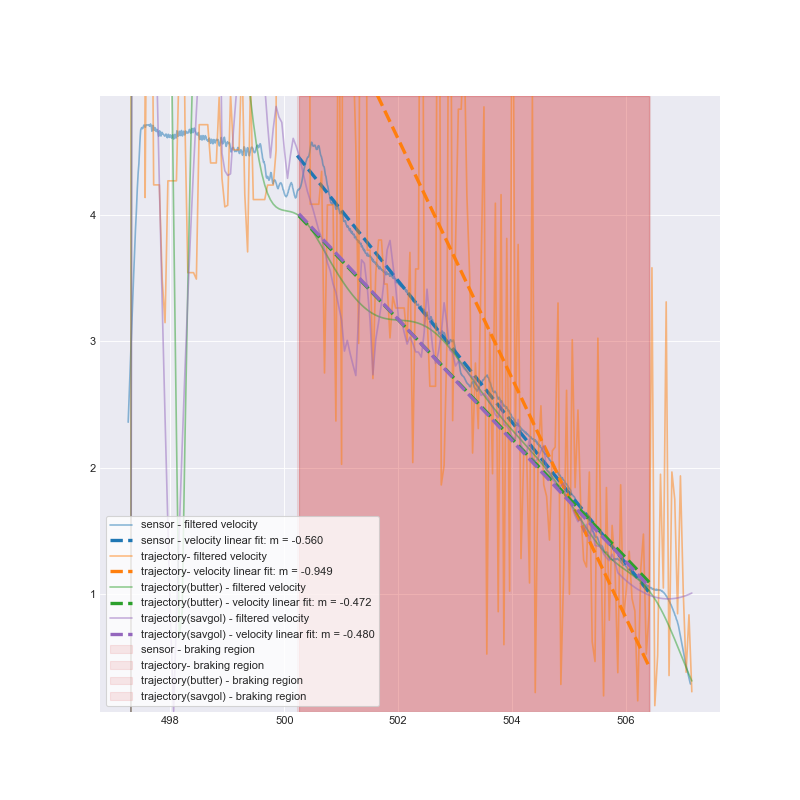

In [245]:
def plot_brake_linear_fit(event, fitparams, label_prefix=None, **fig_kw):
    if not isinstance(fitparams, list):
        fitparams = [fitparams]
        if label_prefix is not None:
            label_prefix = [label_prefix]
        
    color = sns.color_palette('tab10', 10)
    fig, ax = plt.subplots(**fig_kw)
    
    ylim = None
    for i, fit in enumerate(fitparams):
        if label_prefix is None:
            prefix = 'fit {} - '.format(i)
        else:
            prefix = label_prefix[i]
        j = i % 9
        if j >= 3:
            # skip red color for displaying fits
            j += 1
        
        braking_time = fit.signal_time[fit.braking_slice][[0, -1]]
        ax.axvspan(*braking_time,
                   color=color[3], alpha=0.1,
                   label=prefix + 'braking region')
            
        ax.plot(fit.signal_time,
                fit.filtered_velocity,
                color=color[j], alpha=0.5,
                label=prefix + 'filtered velocity')
        
        m = fit.linregress_slope
        b = fit.linregress_intercept
        ax.plot(braking_time,
                braking_time*m + b,
                color=color[j], linestyle='--', linewidth=3,
                label=prefix + 'velocity linear fit: m = {:0.3f}'.format(m))
    
        if np.any(fit.lockup_mask):
            # plot lockup regions
            clumps = np.ma.extras._ezclump(fit.lockup_mask)
            for clump in clumps:
                p = ax.axvspan(*fit.signal_time[fit.braking_slice][[clump.start, clump.stop - 1]],
                               fill=False,  hatch='x', color=color[j], alpha=0.3)
            # set label for only one region (if multiple)
            p.set_label(prefix + 'lockup region')
        if ylim is None:
            ylim = ax.get_ylim()
        
    ax.set_ylim(ylim)
    ax.legend(loc='lower left')
    return fig, ax
    
plt.close('all')

fitparams = evt._calculate_brake_event_fit(**metrics_kw)

tlim = evt.bicycle.time[fitparams.braking_slice][[0, -1]]
lidar_indices = evt.lidar.frame_index(lambda t: (t >= tlim[0]) & (t <= tlim[1]))
traj_fitparams = fit_velocity_brake_event(
    evt.lidar.time,
    estimate_trajectory_velocity(evt, mode='interp'),
    lidar_indices)
trajbutter_fitparams = fit_velocity_brake_event(
    evt.lidar.time,
    estimate_trajectory_velocity(evt, mode='butter'),
    lidar_indices)

x, y = evt.trajectory(mode='interp')
window_length = 55
polyorder = 3
x = scipy.signal.savgol_filter(x, window_length, polyorder)
y = scipy.signal.savgol_filter(y, window_length, polyorder)
trajsavgol_fitparams = fit_velocity_brake_event(
    evt.lidar.time,
    estimate_trajectory_velocity(evt, xy=(x, y)),
    lidar_indices)

fits = [fitparams, traj_fitparams]
plot_brake_linear_fit(evt,
                      [fitparams,
                       traj_fitparams,
                       trajbutter_fitparams,
                       trajsavgol_fitparams],
                      label_prefix=[
                          'sensor - ',
                          'trajectory- ',
                          'trajectory(butter) - ',
                          'trajectory(savgol) - '],
                      figsize=(10, 10))

plt.show()

rider 0, trial 0


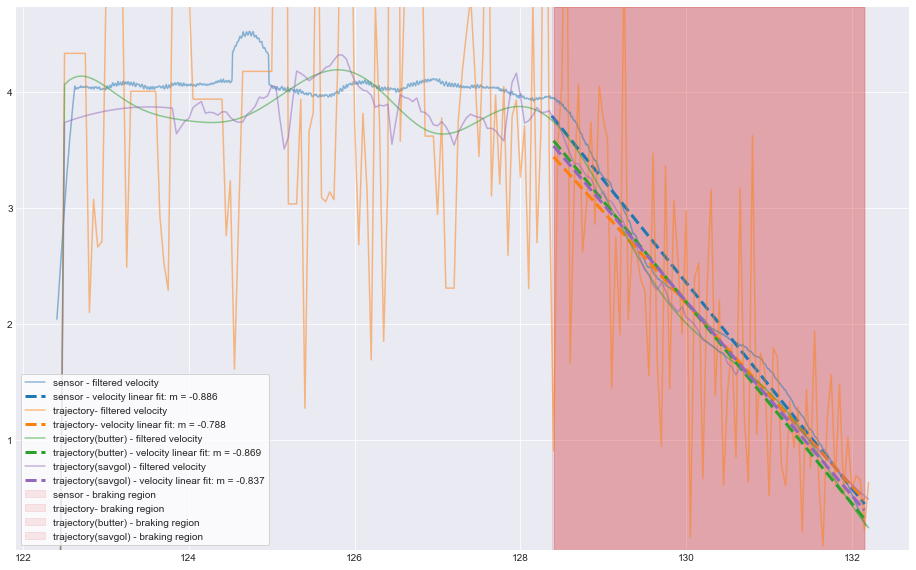

rider 0, trial 1


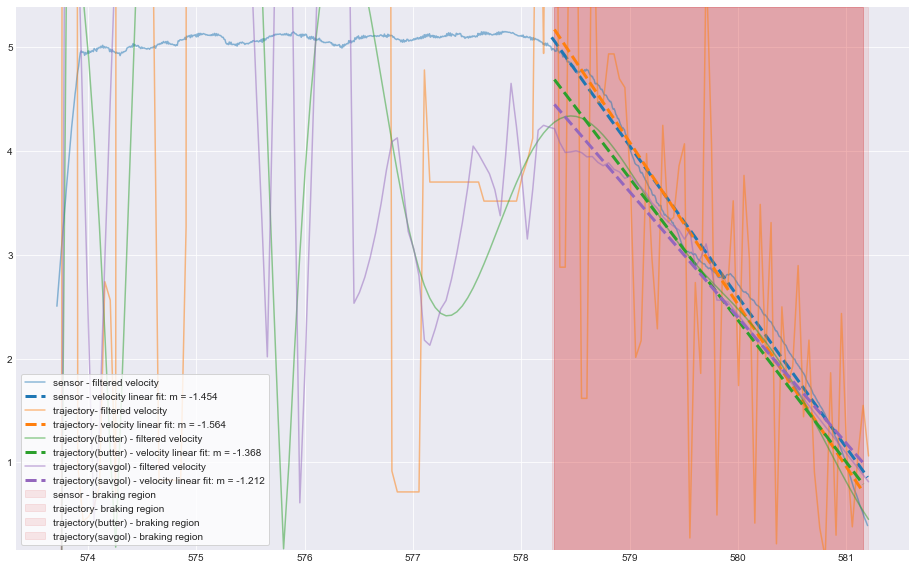

rider 0, trial 2


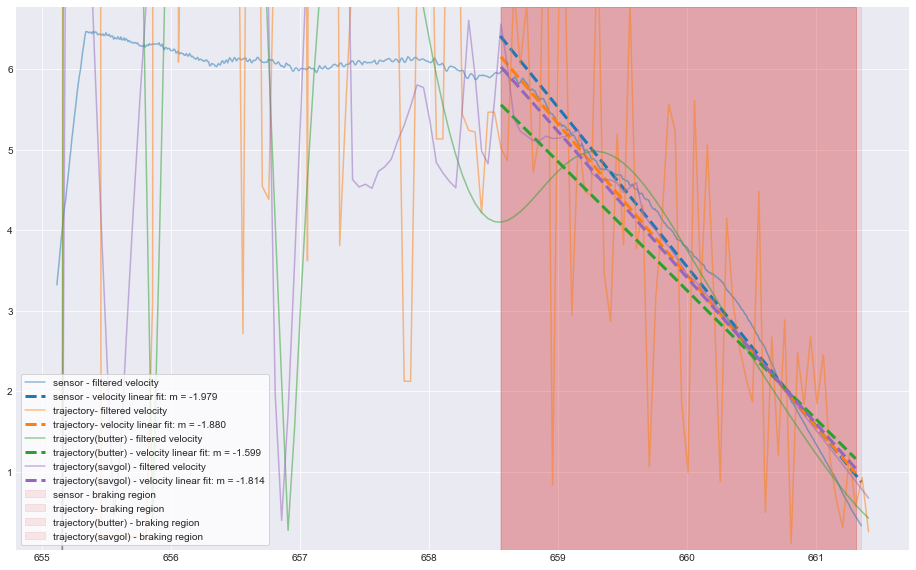

rider 0, trial 6


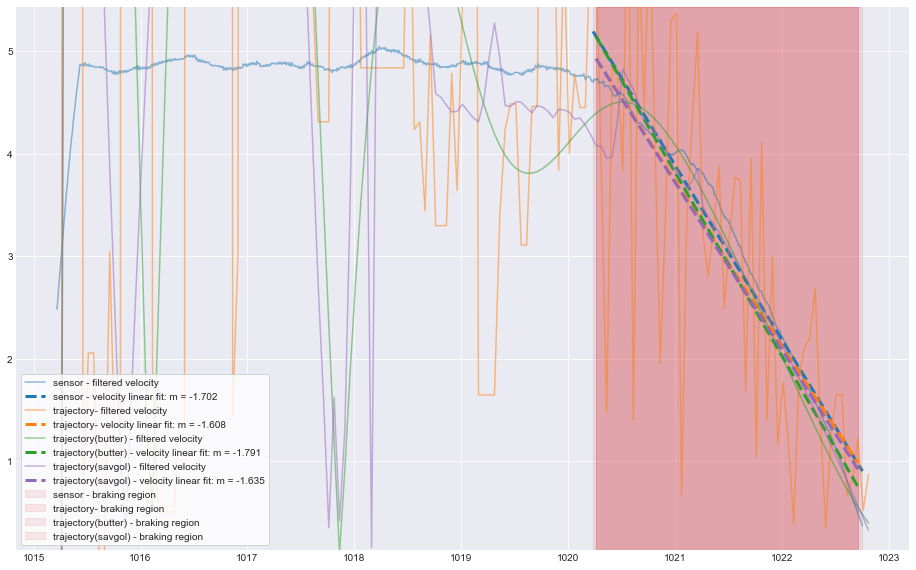

rider 0, trial 7


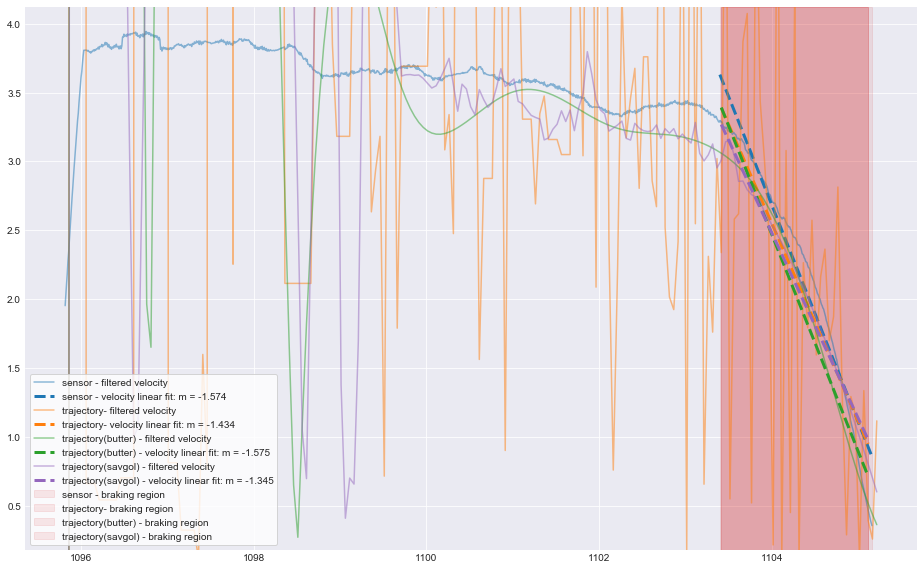

rider 0, trial 8


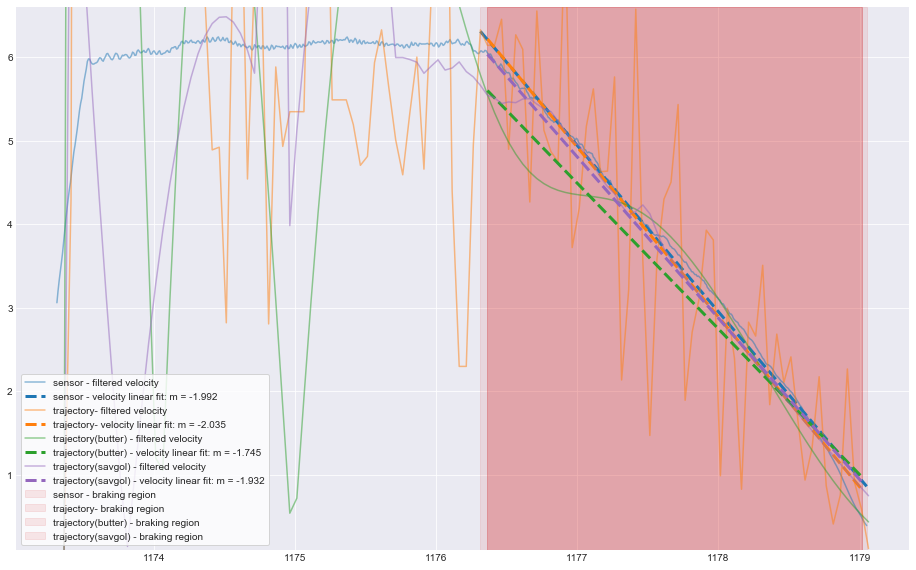

rider 0, trial 12


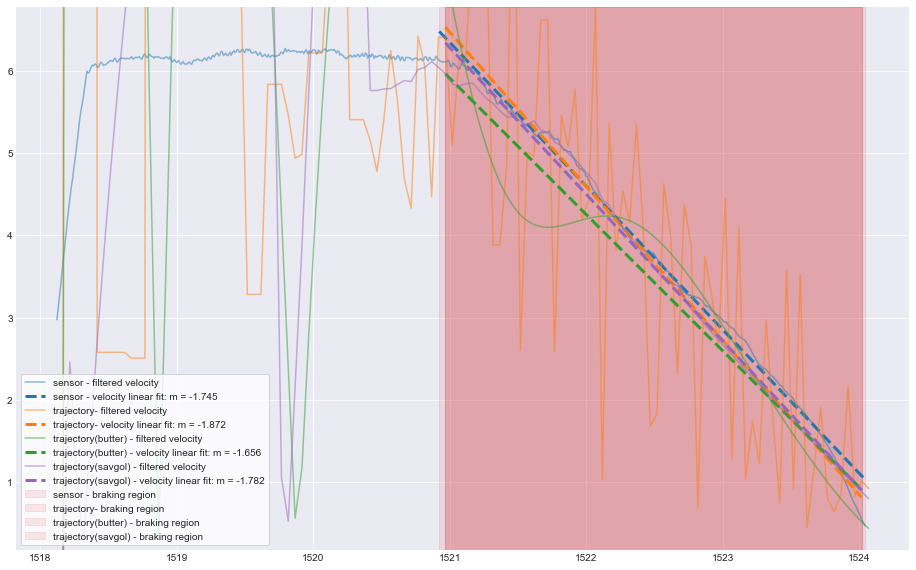

rider 0, trial 13


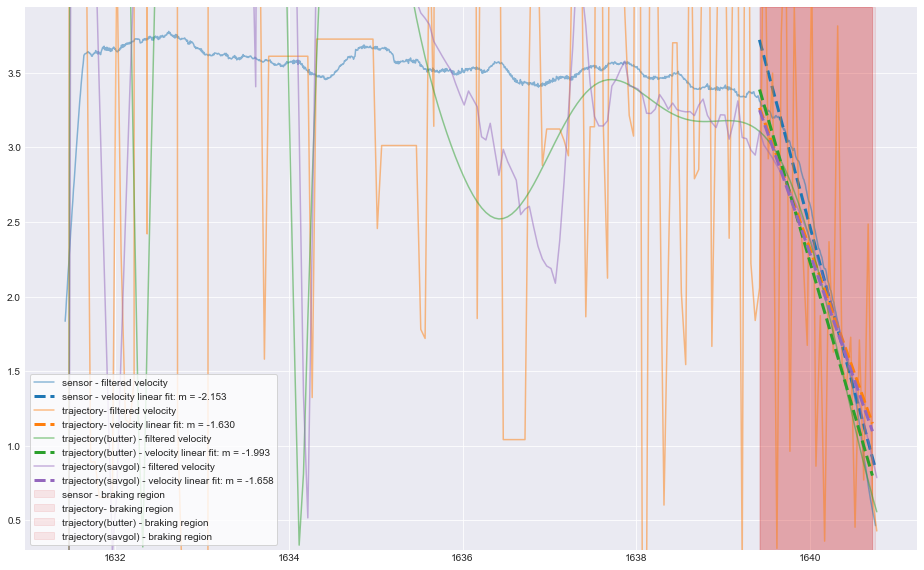

rider 0, trial 14


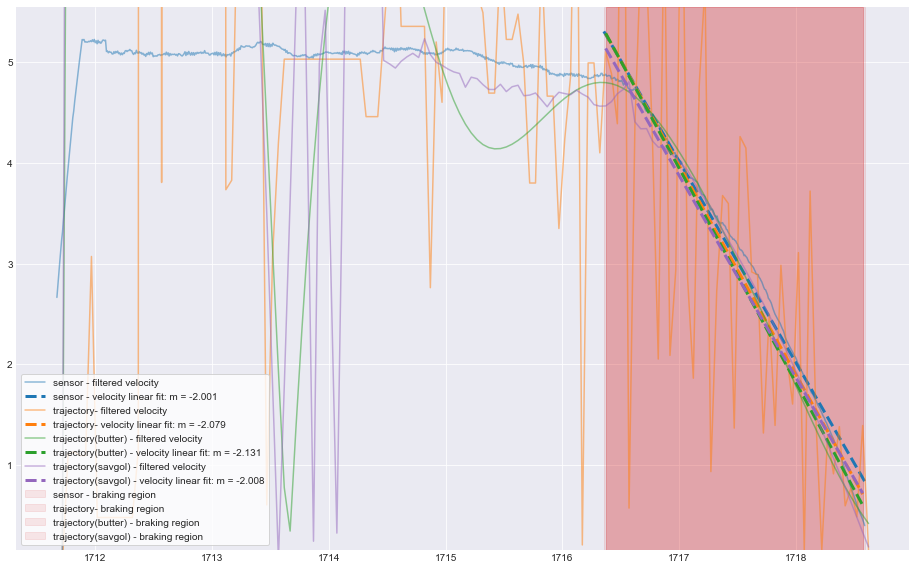

rider 1, trial 3


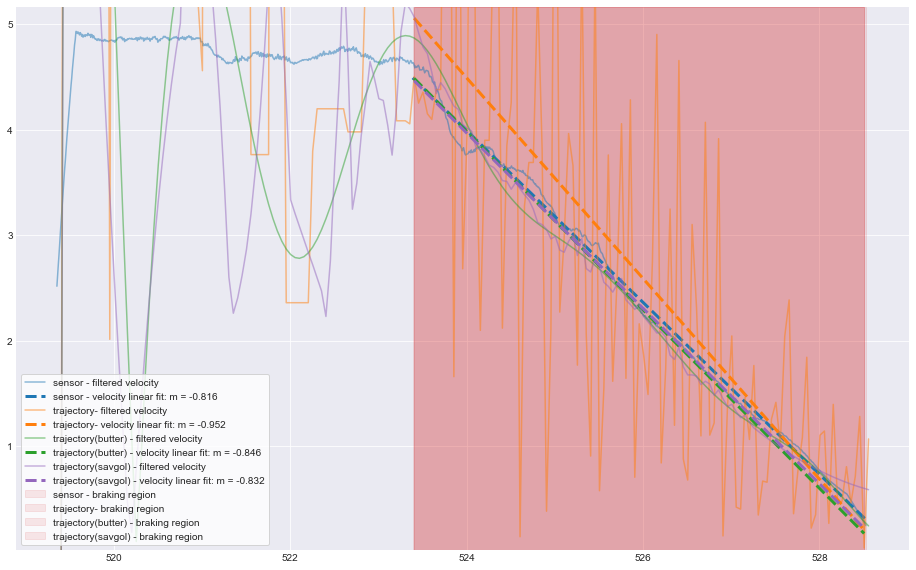

rider 1, trial 4


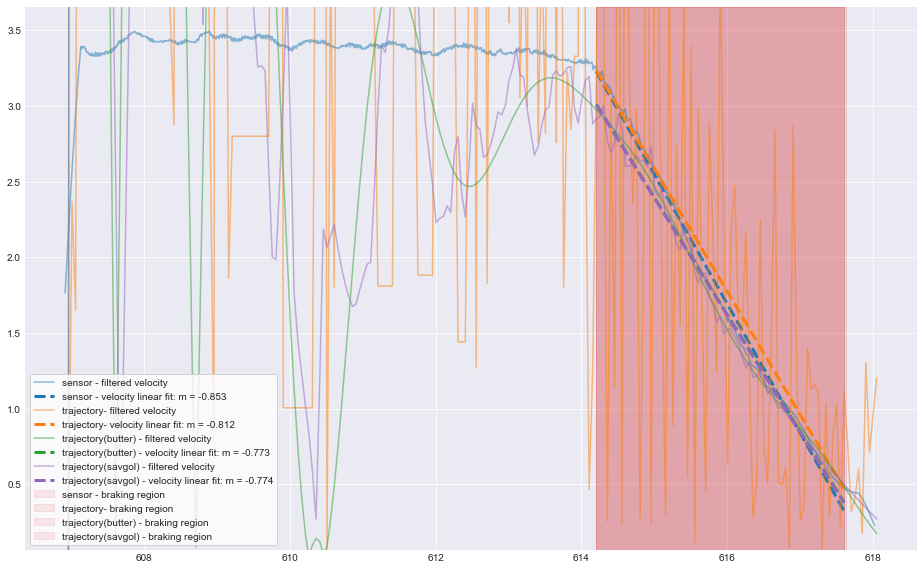

rider 1, trial 5


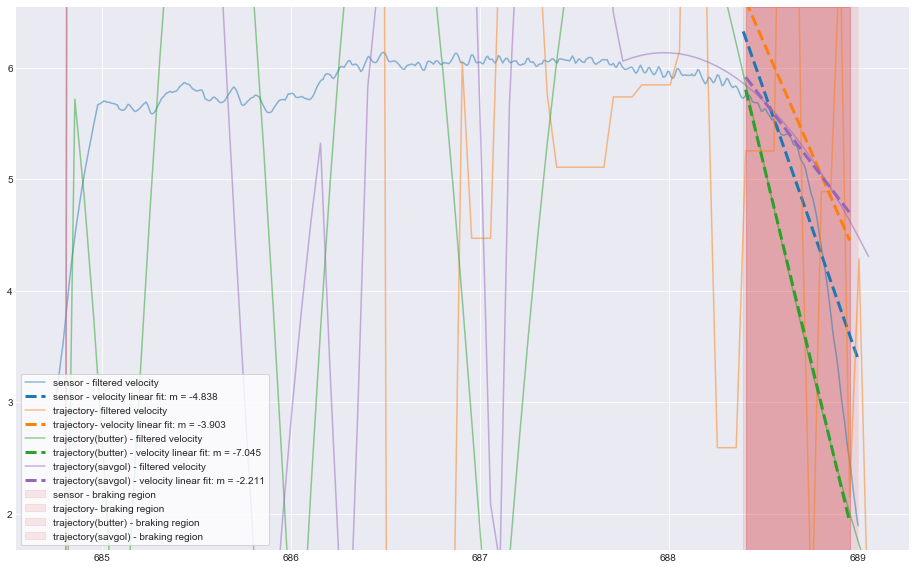

rider 1, trial 9


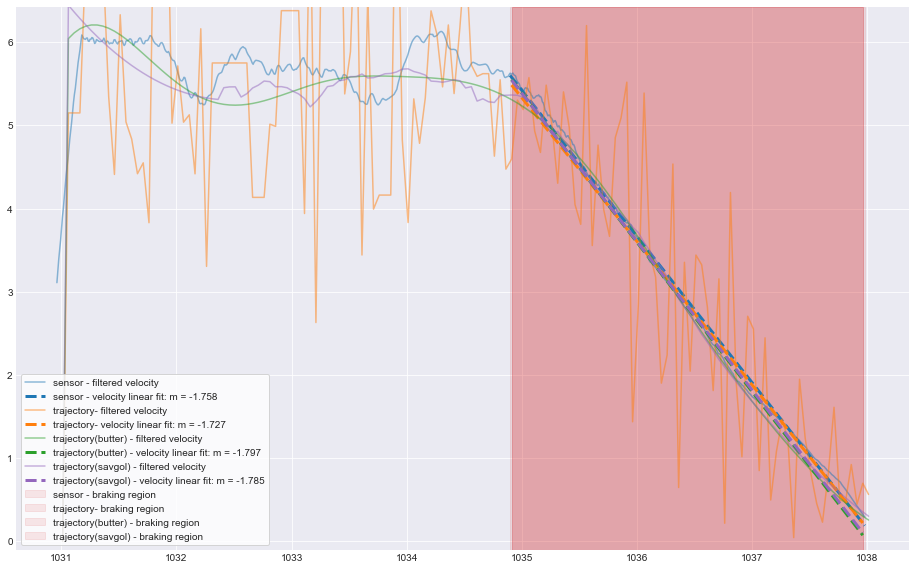

rider 1, trial 10


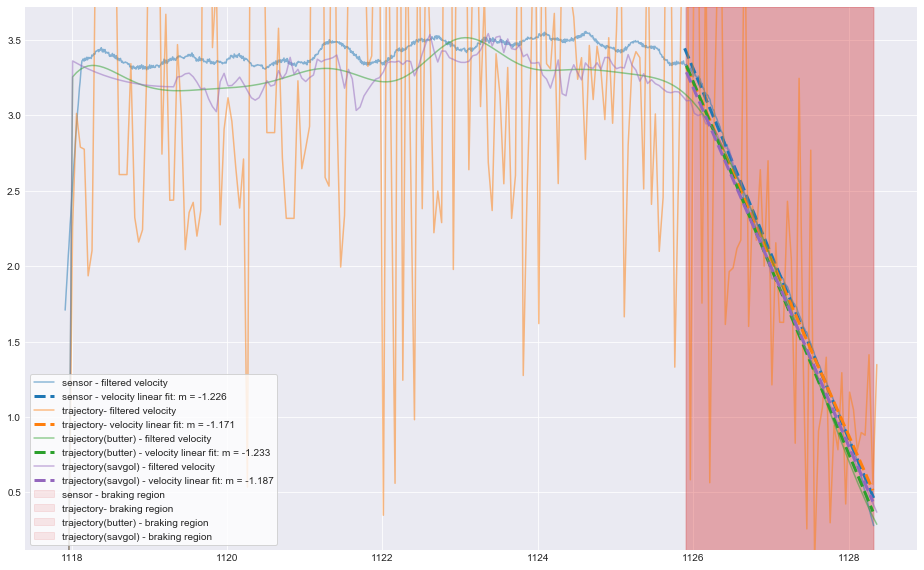

rider 1, trial 11


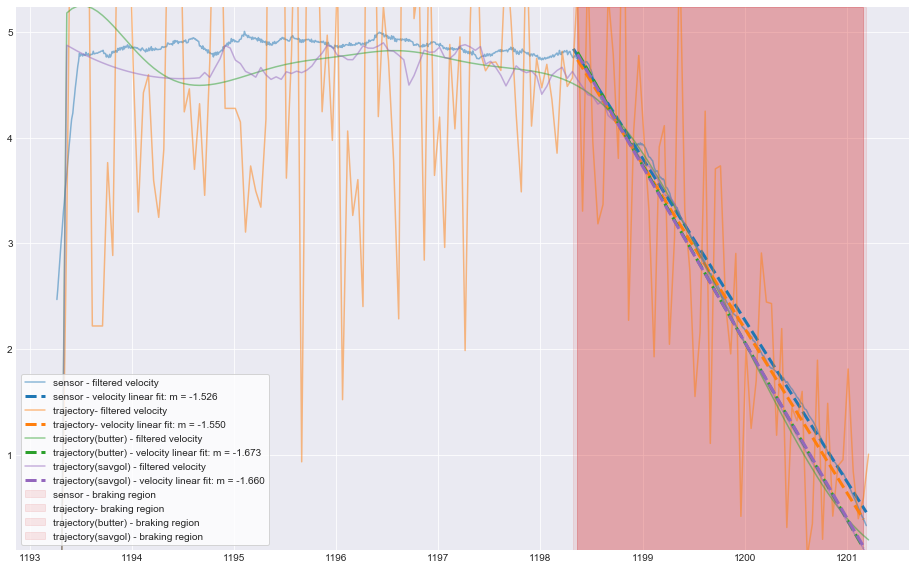

rider 1, trial 15


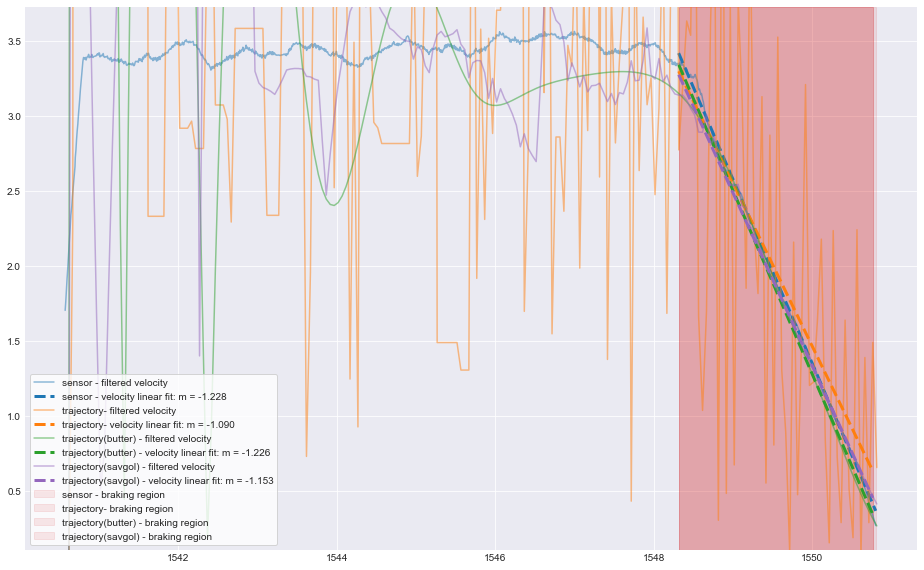

rider 1, trial 16


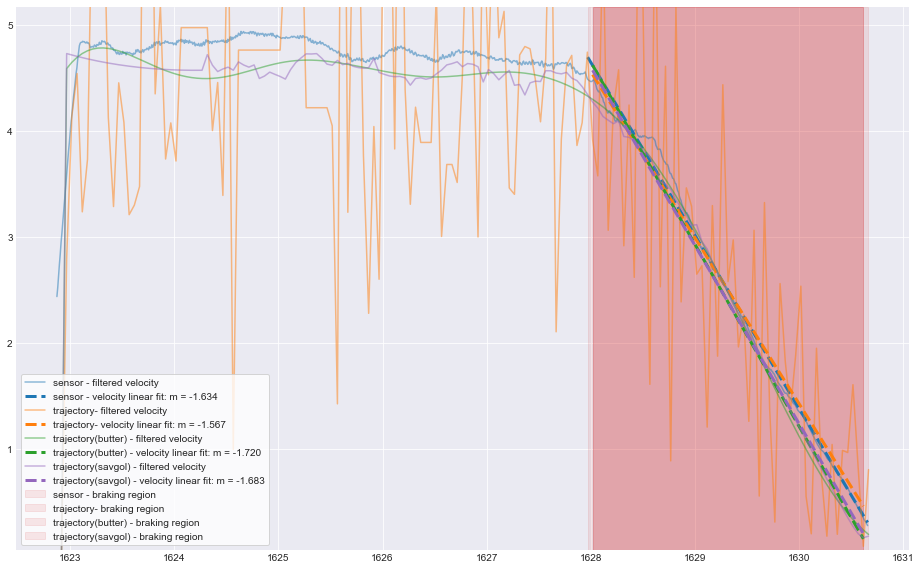

rider 1, trial 17


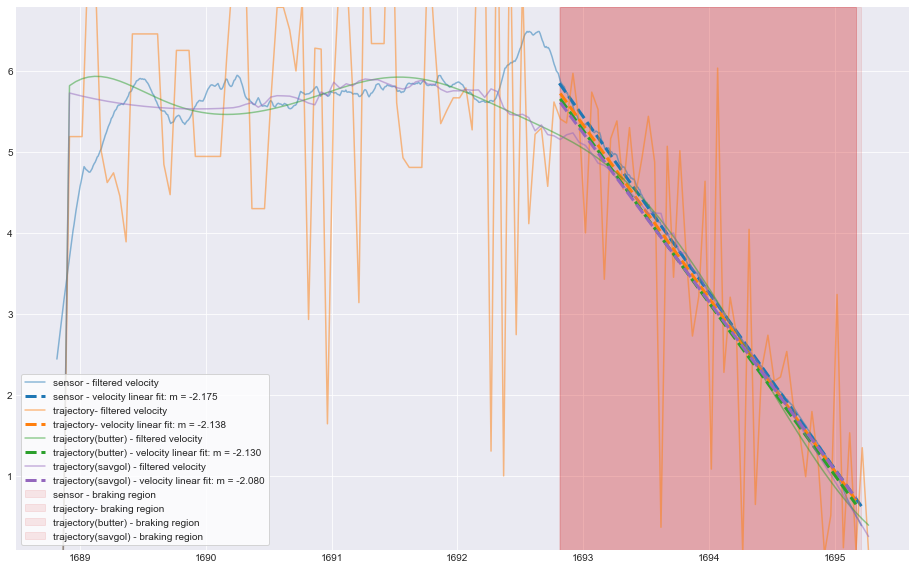

rider 2, trial 0


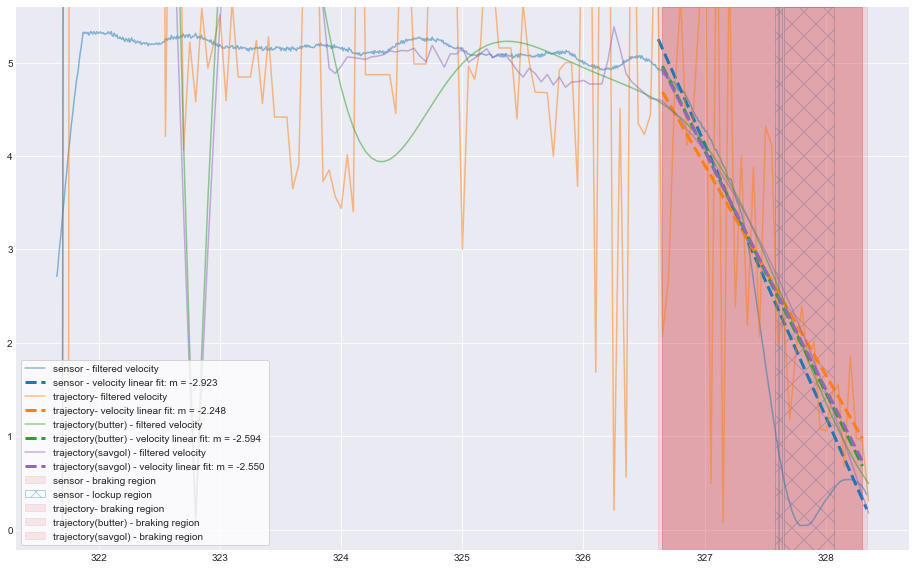

rider 2, trial 1


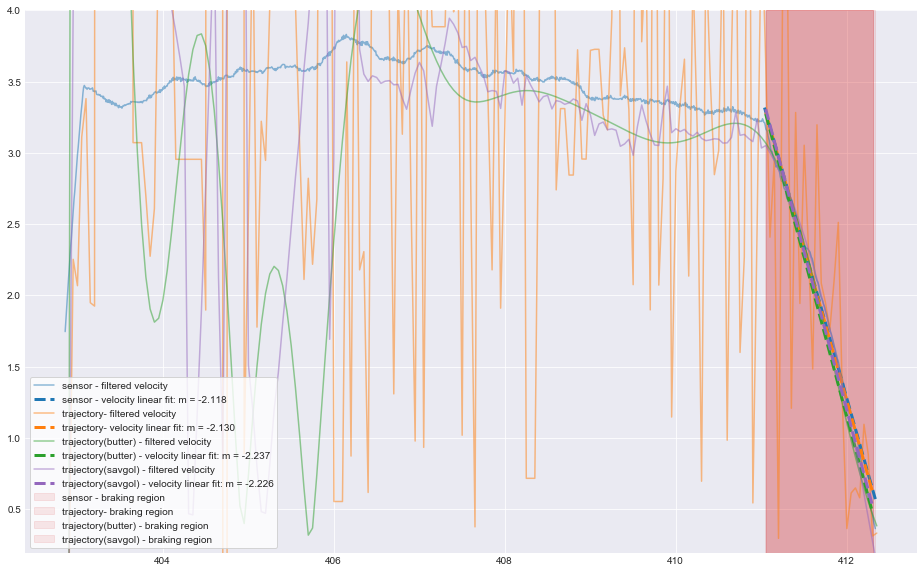

rider 2, trial 2


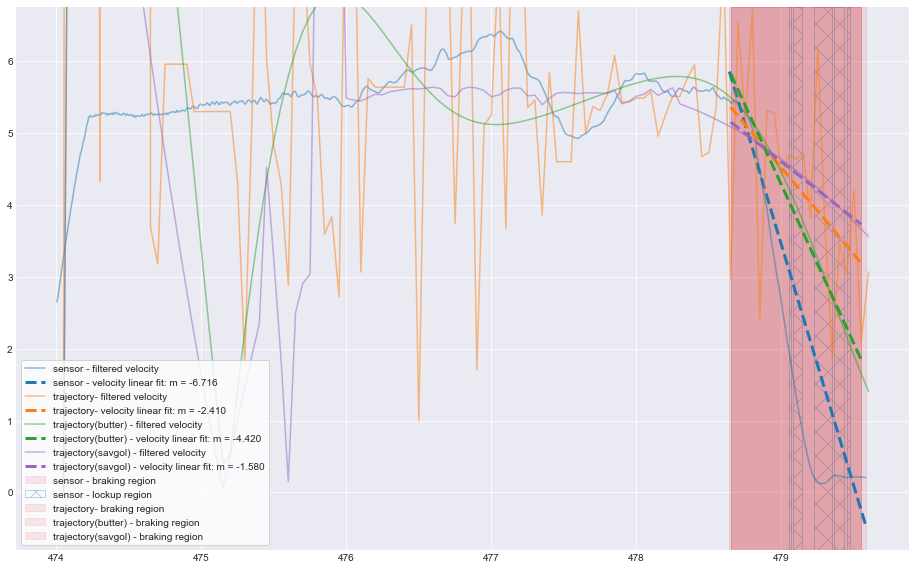

rider 2, trial 6


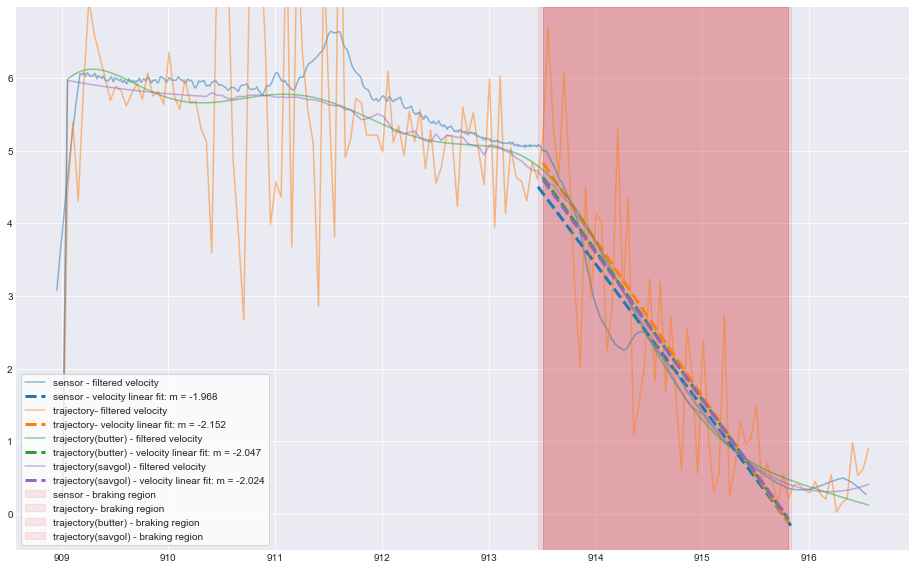

rider 2, trial 7


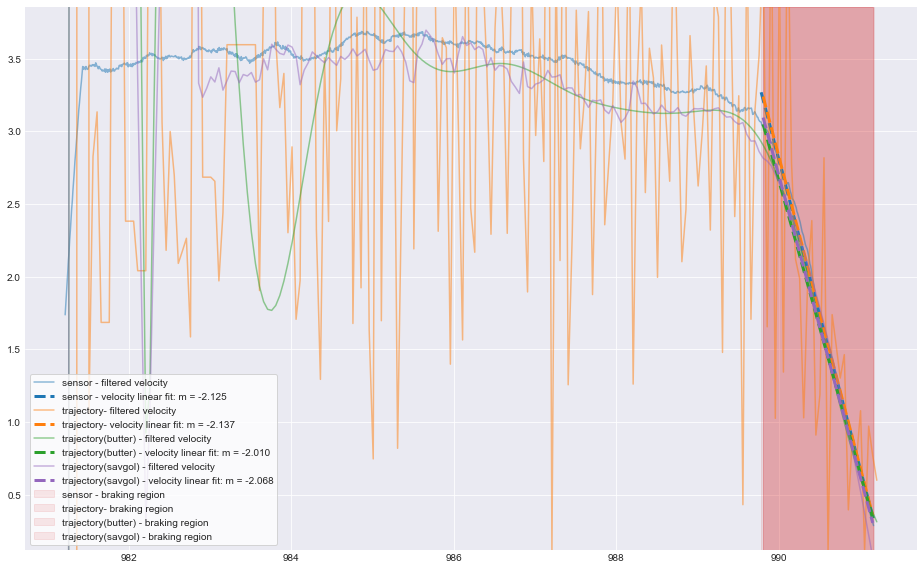

rider 2, trial 8


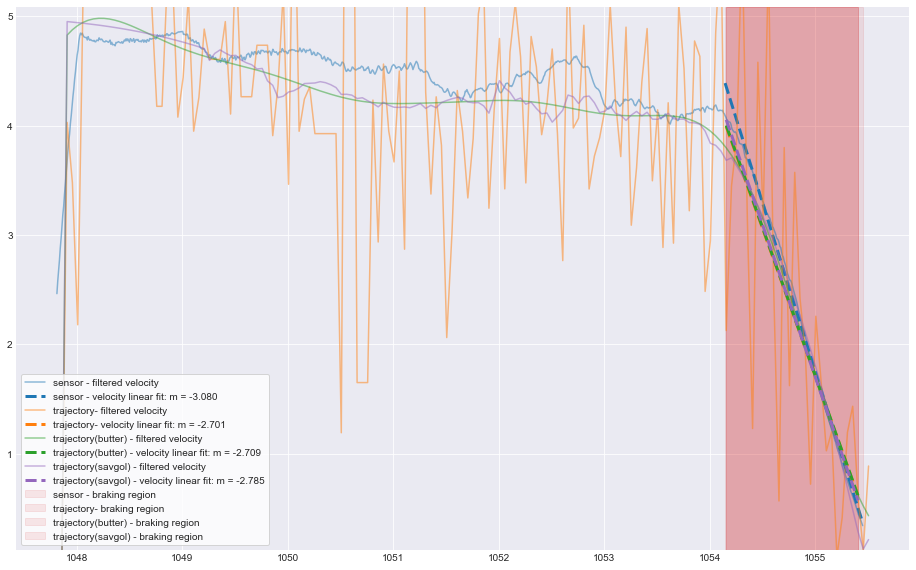

rider 2, trial 12


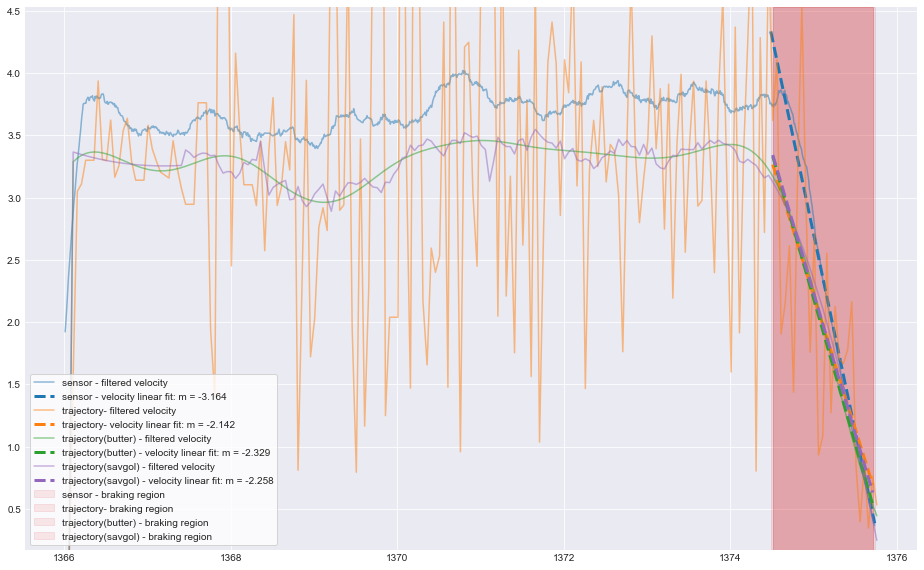

rider 2, trial 13


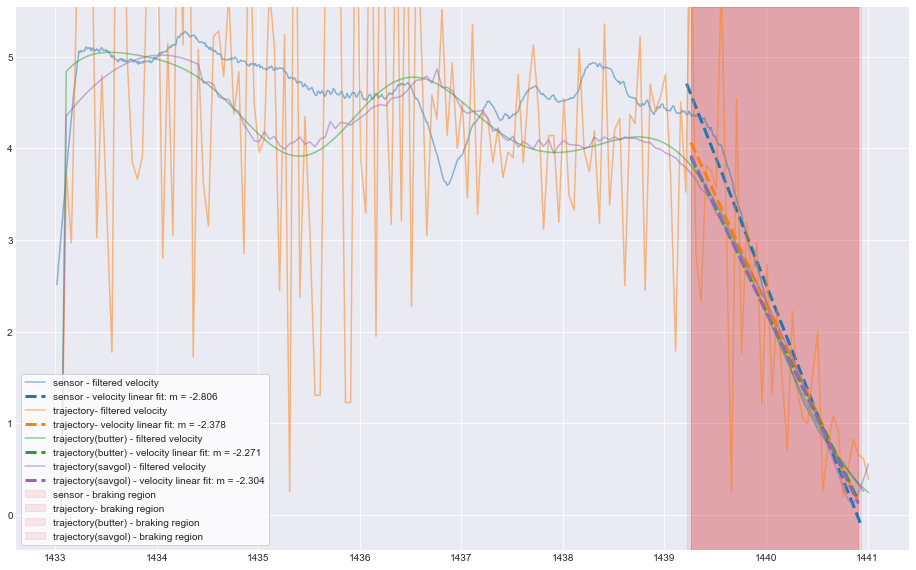

rider 2, trial 14


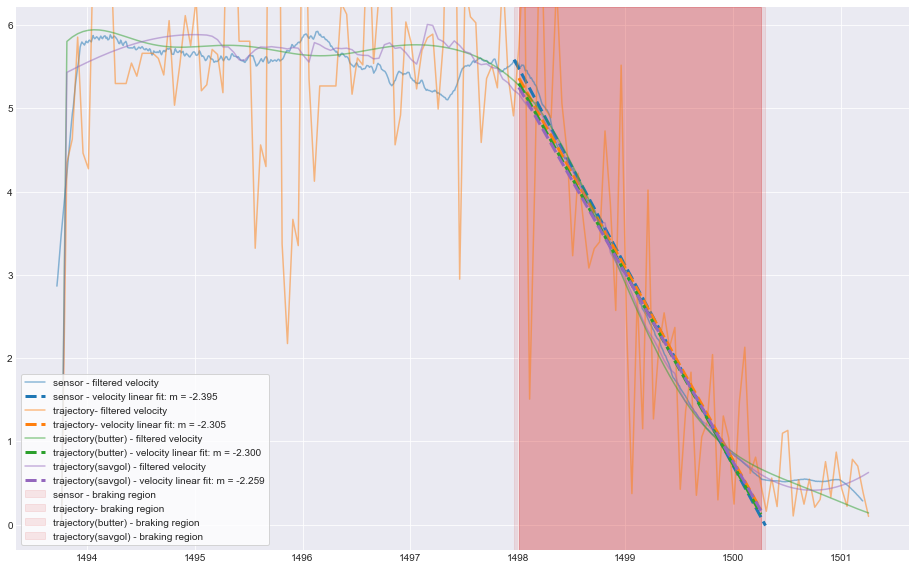

rider 3, trial 3


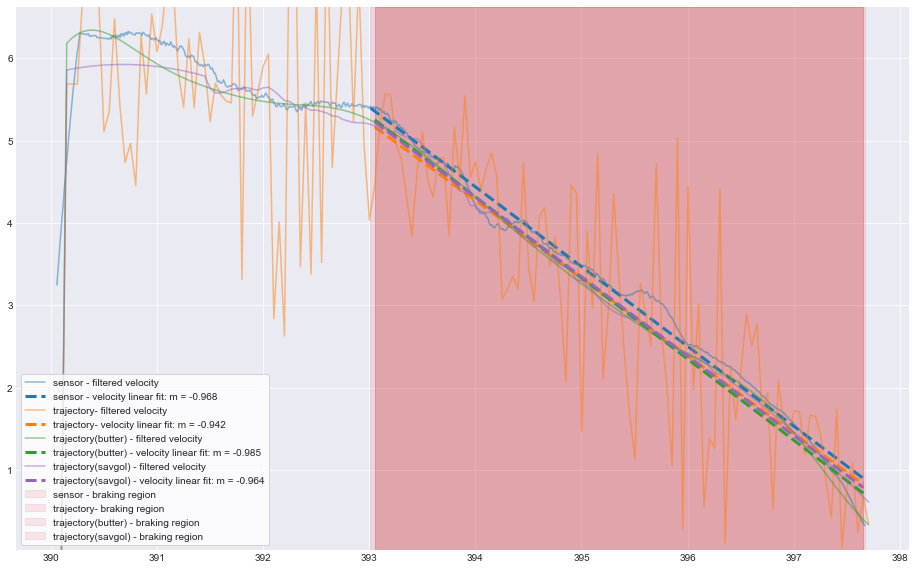

rider 3, trial 4


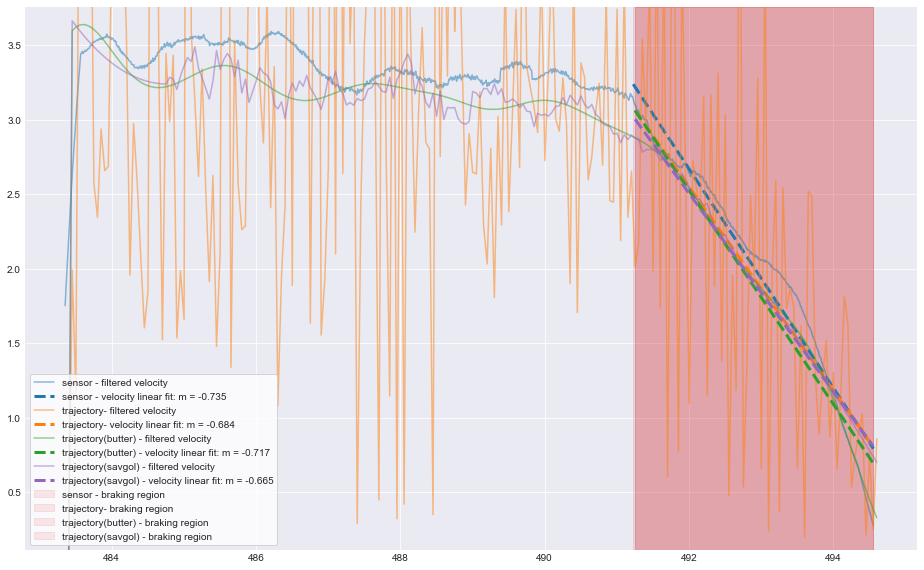

rider 3, trial 5


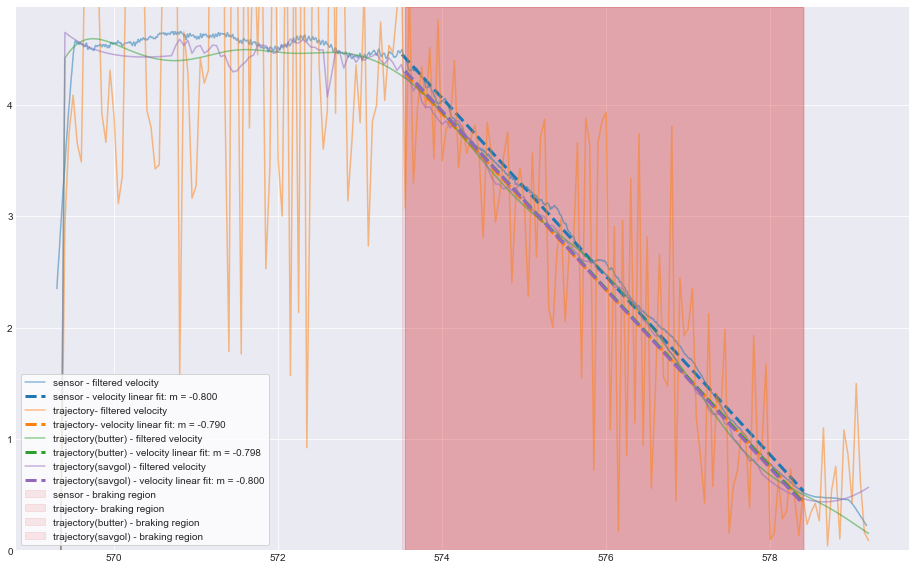

rider 3, trial 9


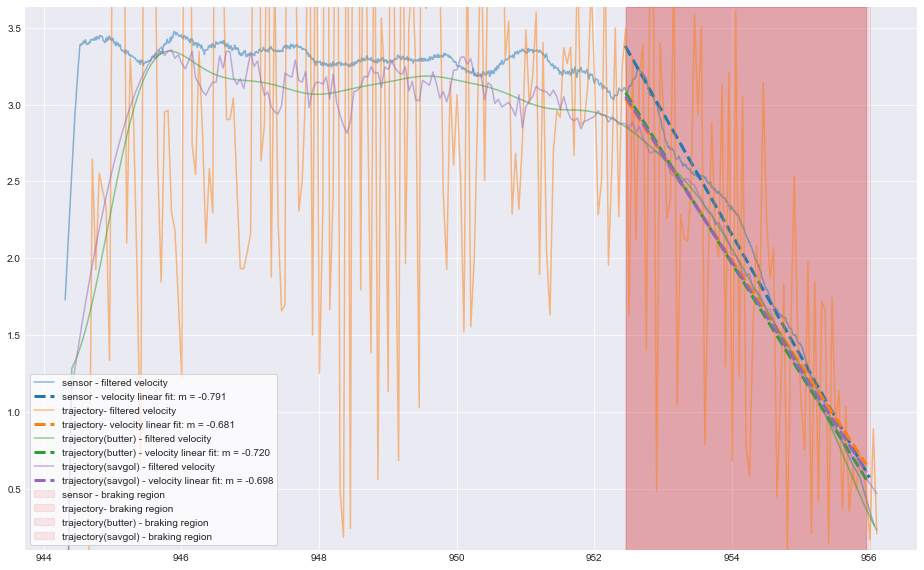

rider 3, trial 10


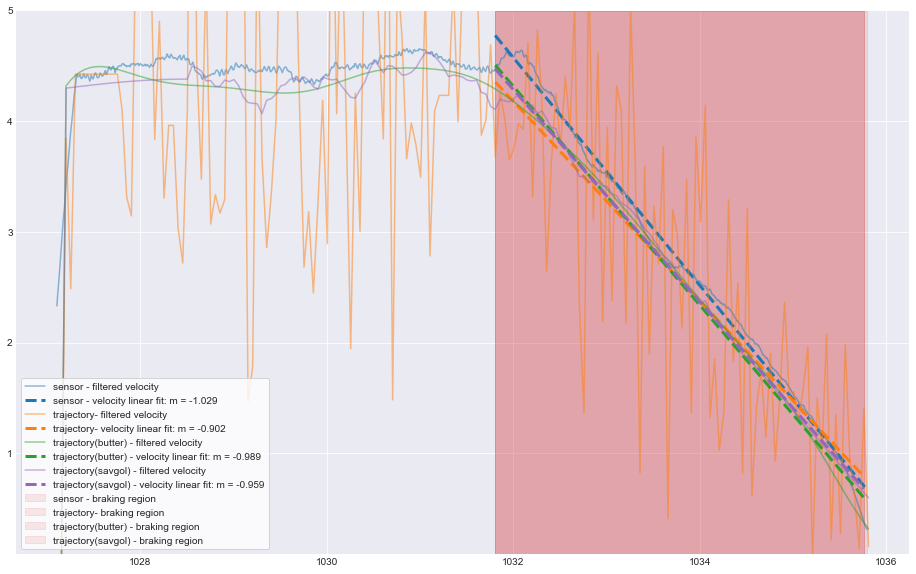

rider 3, trial 11


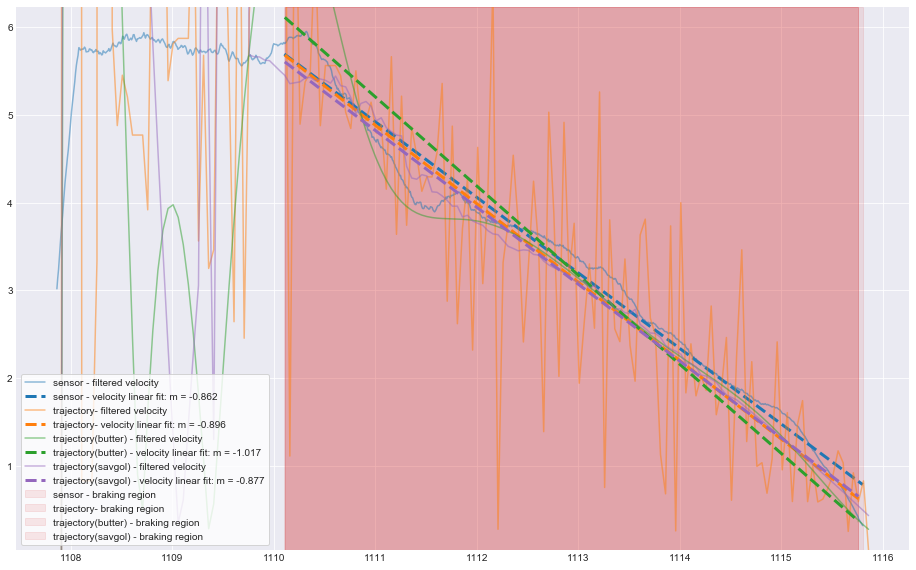

rider 3, trial 15


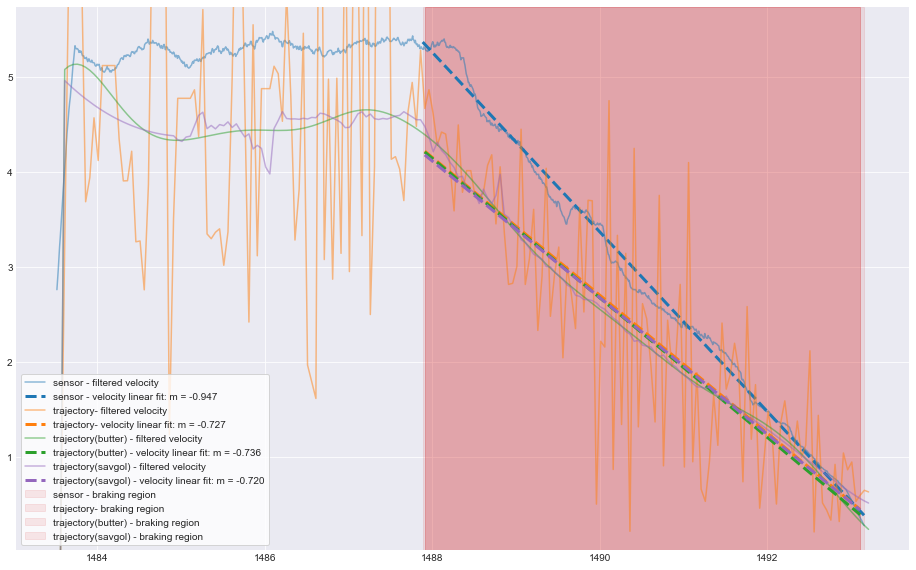

rider 3, trial 16


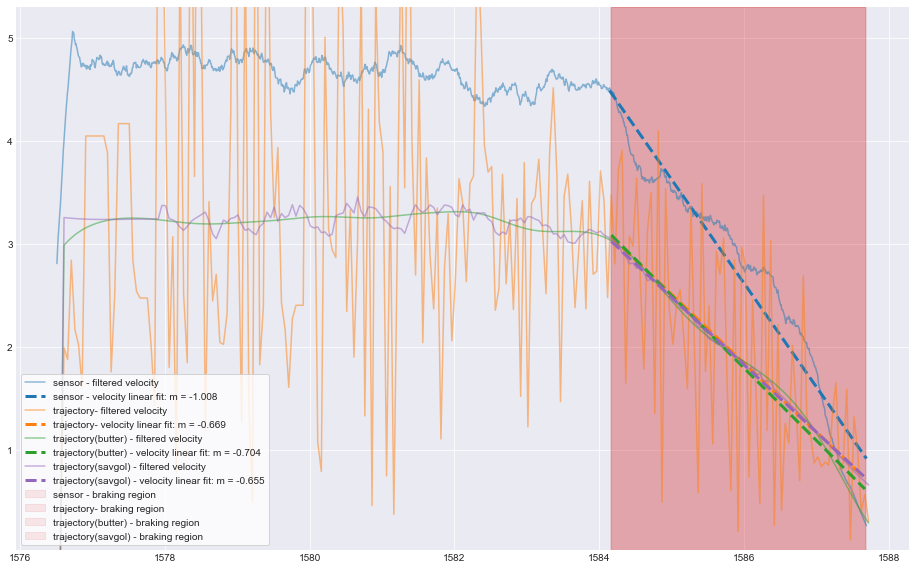

rider 3, trial 17


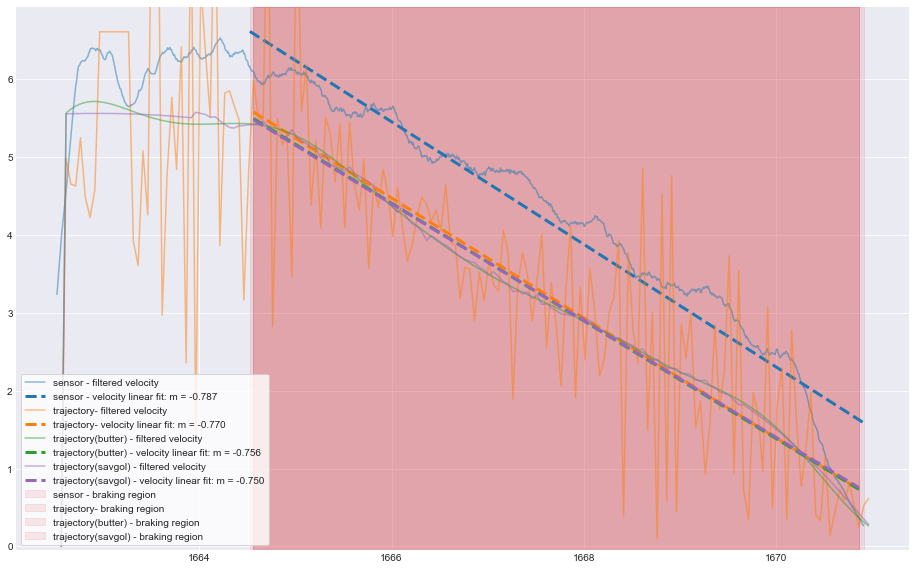

rider 4, trial 0


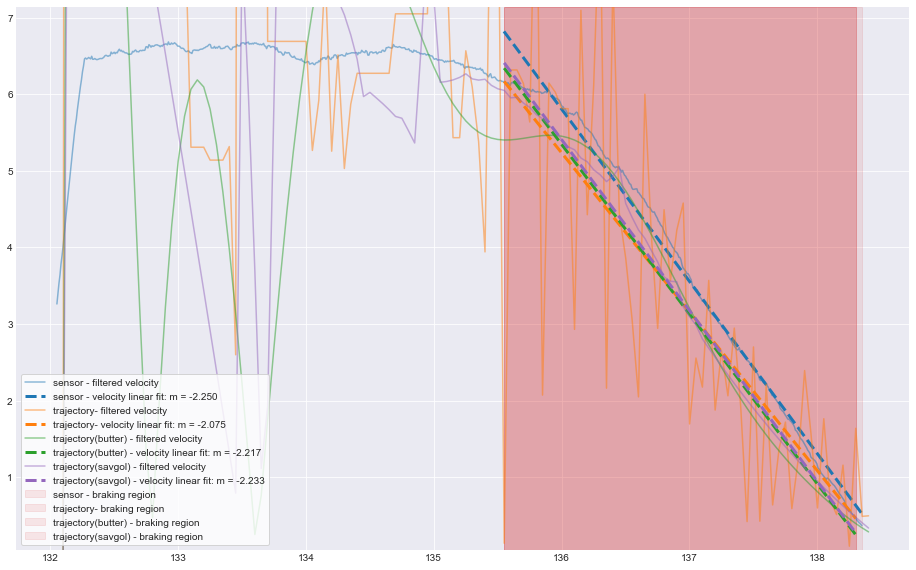

rider 4, trial 1


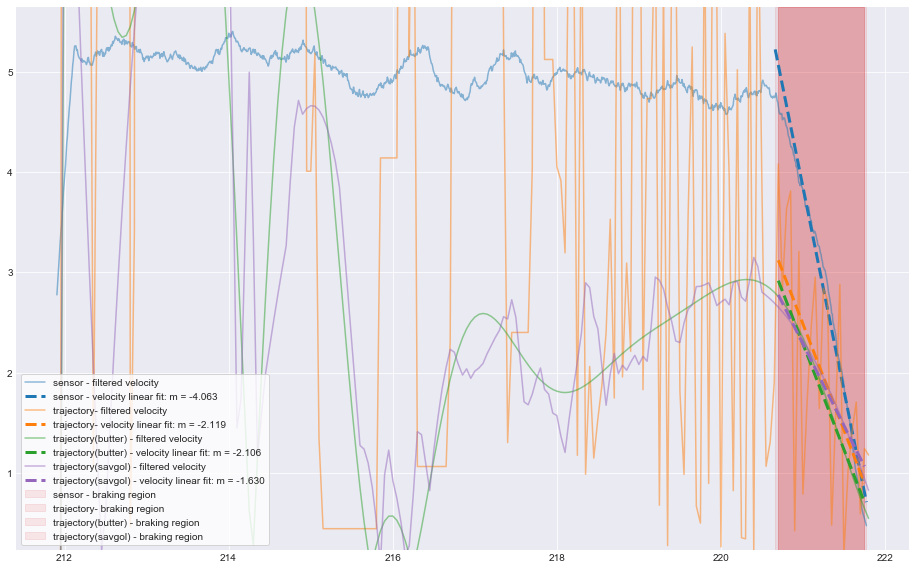

rider 4, trial 2


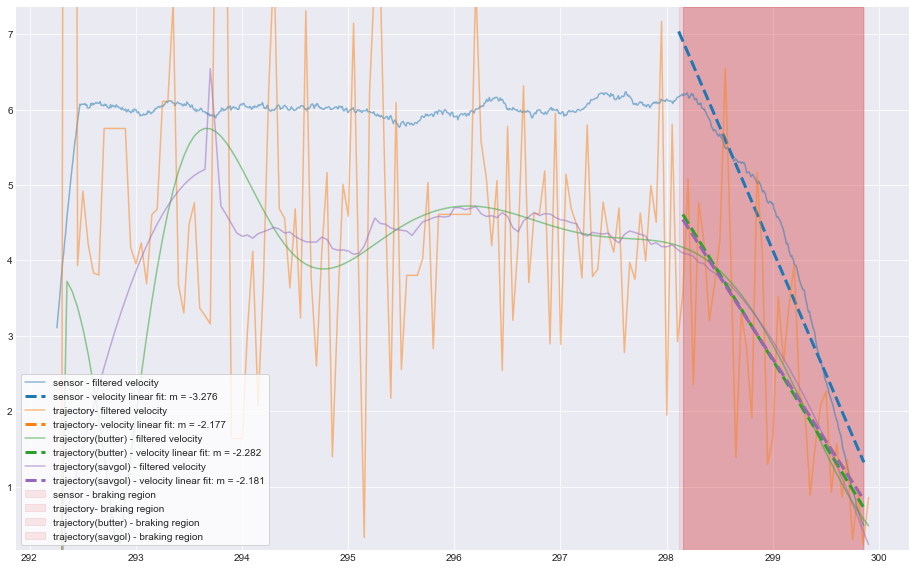

rider 4, trial 6


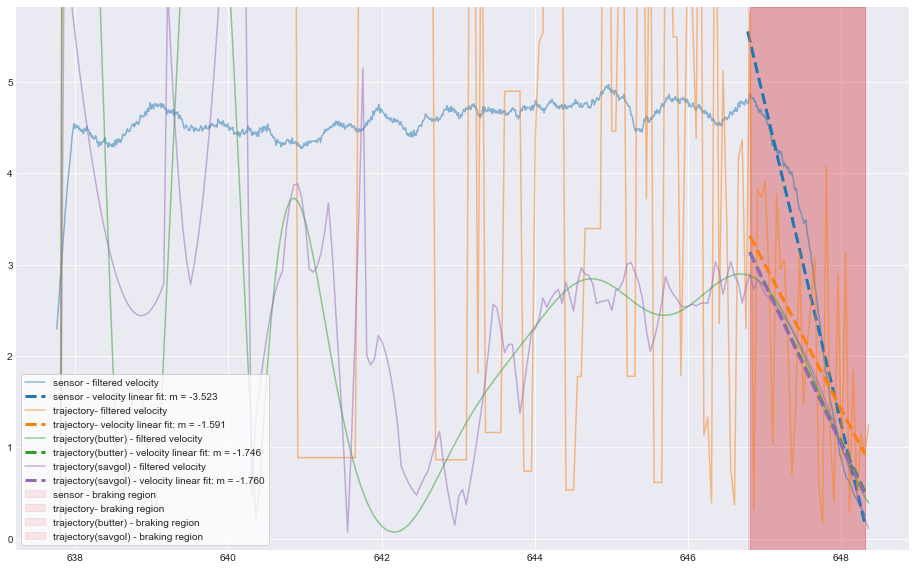

rider 4, trial 7


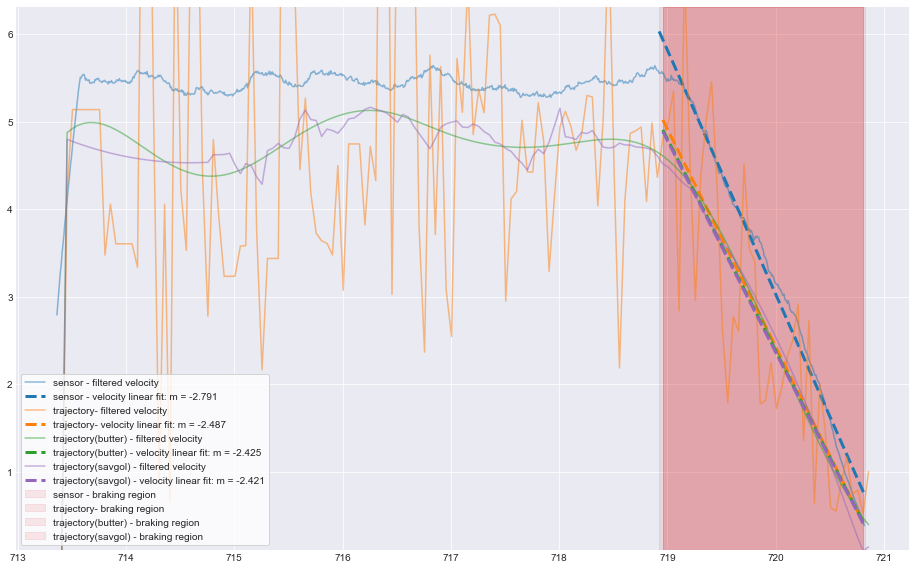

rider 4, trial 8


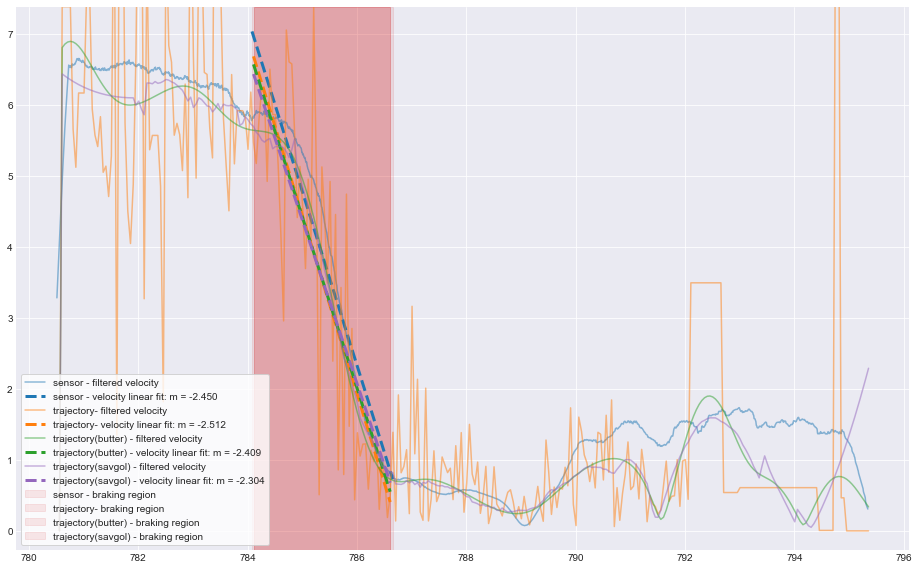

In [ ]:
%matplotlib inline
from antlia.trial2 import EventType

metrics_kw = {'braking_threshold': 0.1, 'min_size': 75}

rider_id = []
trial_id = []

d = {
    'rider id': [],
    'trial id': [],
    'sensor - starting velocity': [],
    'sensor - braking slope': [],
    'trajectory - starting velocity': [],
    'trajectory - braking slope': [],
    'trajectory (butter) - starting velocity': [],
    'trajectory (butter) - braking slope': [],
    'trajectory (savgol) - starting velocity': [],
    'trajectory (savgol) - braking slope': [],
}

plt.close('all')
for i, r in enumerate(records):
    for j, tr in enumerate(r.trials):
        evt = tr.event
        if evt.type.value != EventType.Braking.value:
            continue
            
        fitparams = evt._calculate_brake_event_fit(**metrics_kw)
        
        tlim = evt.bicycle.time[fitparams.braking_slice][[0, -1]]
        lidar_indices = evt.lidar.frame_index(lambda t: (t >= tlim[0]) & (t <= tlim[1]))
        traj_fitparams = fit_velocity_brake_event(
            evt.lidar.time,
            estimate_trajectory_velocity(evt, mode='interp'),
            lidar_indices)
        
        trajbutter_fitparams = fit_velocity_brake_event(
            evt.lidar.time,
            estimate_trajectory_velocity(evt, mode='butter'),
            lidar_indices)
        
        x, y = evt.trajectory(mode='interp')
        window_length = 55
        polyorder = 3
        x = scipy.signal.savgol_filter(x, window_length, polyorder)
        y = scipy.signal.savgol_filter(y, window_length, polyorder)
        trajsavgol_fitparams = fit_velocity_brake_event(
            evt.lidar.time,
            estimate_trajectory_velocity(evt, xy=(x, y)),
            lidar_indices)
        
        d['rider id'].append(i)
        d['trial id'].append(j)
        d['sensor - starting velocity'].append(fitparams.filtered_velocity[fitparams.braking_slice.start])
        d['sensor - braking slope'].append(fitparams.linregress_slope)
        d['trajectory - starting velocity'].append(
            traj_fitparams.filtered_velocity[traj_fitparams.braking_slice[0]])
        d['trajectory - braking slope'].append(traj_fitparams.linregress_slope)
        d['trajectory (butter) - starting velocity'].append(
            trajbutter_fitparams.filtered_velocity[trajbutter_fitparams.braking_slice[0]])
        d['trajectory (butter) - braking slope'].append(trajbutter_fitparams.linregress_slope)
        d['trajectory (savgol) - starting velocity'].append(
            trajsavgol_fitparams.filtered_velocity[trajsavgol_fitparams.braking_slice[0]])
        d['trajectory (savgol) - braking slope'].append(trajsavgol_fitparams.linregress_slope)
        
        print('rider {}, trial {}'.format(i, j))
        fig, ax = plot_brake_linear_fit(evt,
                                        [fitparams,
                                         traj_fitparams,
                                         trajbutter_fitparams,
                                         trajsavgol_fitparams],
                                        label_prefix=[
                                            'sensor - ',
                                            'trajectory- ',
                                            'trajectory(butter) - ',
                                            'trajectory(savgol) - '],
                                        figsize=(16, 10))
        plt.show()
        
df = pd.DataFrame(data=d)

In [247]:
cols = ['rider id',
        'trial id',
        'sensor - starting velocity',
        'sensor - braking slope',
        'trajectory - starting velocity',
        'trajectory - braking slope',
        'trajectory (butter) - starting velocity',
        'trajectory (butter) - braking slope']
df = df[cols]
        
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'float_format', '{:0.3f}'.format):
    display(df)

rider id  trial id  sensor - starting velocity  sensor - braking slope  \
0          0         0                       3.950                  -0.886   
1          0         1                       4.973                  -1.454   
2          0         2                       5.960                  -1.979   
3          0         6                       4.697                  -1.702   
4          0         7                       3.297                  -1.574   
5          0         8                       6.077                  -1.992   
6          0        12                       6.124                  -1.745   
7          0        13                       3.311                  -2.153   
8          0        14                       4.872                  -2.001   
9          1         3                       4.634                  -0.816   
10         1         4                       3.256                  -0.853   
11         1         5                       5.728                  -4.838   
12         1         9                       5.629                  -1.758   
13         1        10                       3.336                  -1.226   
14         1        11                       4.753                  -1.526   
15         1        15                       3.351                  -1.228   
16         1        16                       4.492                  -1.634   
17         1        17                       5.917                  -2.175   
18         2         0                       4.920                  -2.923   
19         2         1                       3.211                  -2.118   
20         2         2                       5.440                  -6.716   
21         2         6                       5.073                  -1.968   
22         2         7                       3.064                  -2.125   
23         2         8                       4.090                  -3.080   
24         2        12                       3.760                  -3.164   
25         2        13                       4.369                  -2.806   
26         2        14                       5.561                  -2.395   
27         3         3                       5.413                  -0.968   
28         3         4                       3.138                  -0.735   
29         3         5                       4.496                  -0.800   
30         3         9                       3.106                  -0.791   
31         3        10                       4.474                  -1.029   
32         3        11                       5.816                  -0.862   
33         3        15                       5.295                  -0.947   
34         3        16                       4.520                  -1.008   
35         3        17                       6.163                  -0.787   
36         4         0                       6.159                  -2.250   
37         4         1                       4.752                  -4.063   
38         4         2                       6.170                  -3.276   
39         4         6                       4.764                  -3.523   
40         4         7                       5.555                  -2.791   
41         4         8                       5.795                  -2.450   
42         4        12                       6.134                  -3.404   
43         4        13                       3.405                  -1.753   
44         4        14                       6.265                  -2.664   
45         5         3                       3.932                  -2.040   
46         5         4                       4.498                  -1.500   
47         5         5                       5.969                  -1.798   
48         5         9                       4.927                  -1.232   
49         5        10                       3.733                  -1.299   
50         5        11    

In [257]:
import scipy.stats

result = scipy.stats.ttest_ind(df['sensor - braking slope'].values,
                               df['trajectory (butter) - braking slope'].values)
display(result)

result = scipy.stats.ttest_rel(df['sensor - braking slope'].values,
                               df['trajectory (butter) - braking slope'].values)
display(result)

result = scipy.stats.linregress(df['sensor - braking slope'].values,
                                df['trajectory (butter) - braking slope'].values)
display(result)

Ttest_indResult(statistic=-0.86359241233219763, pvalue=0.38928893520833185)

Ttest_relResult(statistic=-2.3419567684226128, pvalue=0.022033418973270824)

LinregressResult(slope=0.77725632340552187, intercept=-0.23680349060606054, rvalue=0.86945941841859553, pvalue=8.0753998453100743e-23, stderr=0.053164434031121414)

In [346]:
samples = []
for i in df['rider id'].unique():
    dfi = df[df['rider id'] == i]
    samples.append((
        dfi['sensor - braking slope'].values.mean(),
        dfi['trajectory (butter) - braking slope'].values.mean()
    ))
    
result = scipy.stats.ttest_rel(*zip(*samples))
display(result)

Ttest_relResult(statistic=-1.3603386644653208, pvalue=0.21590268058842543)

In [352]:
braking_df = pd.read_pickle('trial2_braking_ttc.p.gz')

assert df.shape[0] == braking_df.shape[0]

samples = []
for (_, row), (_, braking_row) in zip(df.iterrows(), braking_df.iterrows()):
    assert row['rider id'] == braking_row['rider id']
    assert row['trial id'] == braking_row['trial id']
    
    a = row['sensor - braking slope']
    b = row['trajectory (butter) - braking slope']
    
    # skip trial if wheel lockup occurs
    if braking_row['lockup ranges']:
        print('skipping {}-{} due to wheel lockup'.format(
            int(row['rider id']), int(row['trial id'])))
        continue
        
    # skip trial if either fit value exceeds 4 m/s^2
    if abs(a) > 4 or abs(b) > 4:
        print('skipping {}-{} due to invalid deceleration'.format(
            int(row['rider id']), int(row['trial id'])))
        continue
    samples.append((a, b))
    
display(scipy.stats.ttest_rel(*zip(*samples)))
display(scipy.stats.linregress(*zip(*samples)))

skipping 1-5 due to invalid deceleration
skipping 2-0 due to wheel lockup
skipping 2-2 due to wheel lockup
skipping 4-1 due to invalid deceleration


Ttest_relResult(statistic=-3.1552711098193229, pvalue=0.0024154248174041962)

LinregressResult(slope=0.73813302018805294, intercept=-0.28578797196981887, rvalue=0.91777697902657585, pvalue=9.0801970780455656e-28, stderr=0.039612892988136937)

In [353]:
print('excluding invalid trials')
a, b = zip(*samples)
print(np.mean(a))
print(np.mean(b))
print(np.mean(a) - np.mean(b))

print('\nall trials')
a = df['sensor - braking slope'].values.mean()
b = df['trajectory (butter) - braking slope'].values.mean()
print(a)
print(b)
print(a - b)

excluding invalid trials
-1.56022477275
-1.43744139565
-0.122783377099

all trials
-1.73345180976
-1.58413987106
-0.149311938699
